In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# the function for data value normalize
def normalizer(req):
    nrmlzr = StandardScaler()
    req_np = req.to_numpy().reshape(-1, 1)
    nrmlzr.fit(req_np)
    return nrmlzr.transform(req_np)

# read train and test data
data_train = pd.read_csv('./data/price_train.csv')
data_test = pd.read_csv('./data/price_test.csv')

# preprocess
train_x = data_train[['Open Price', 'Close Price', 'High Price', 'Low Price', 'Volume']]
train_x['Open Price'] = normalizer(train_x['Open Price'])
train_x['Close Price'] = normalizer(train_x['Close Price'])
train_x['High Price'] = normalizer(train_x['High Price'])
train_x['Low Price'] = normalizer(train_x['Low Price'])
train_x['Volume'] = normalizer(train_x['Volume'])
train_x = train_x[0:-1]
train_y = data_train['Close Price'][1:]

test_x = data_test[['Open Price', 'Close Price', 'High Price', 'Low Price', 'Volume']]
test_x['Open Price'] = normalizer(test_x['Open Price'])
test_x['Close Price'] = normalizer(test_x['Close Price'])
test_x['High Price'] = normalizer(test_x['High Price'])
test_x['Low Price'] = normalizer(test_x['Low Price'])
test_x['Volume'] = normalizer(test_x['Volume'])
test_x = test_x[0:-1]
test_y = data_test['Close Price'][1:]

LR train predict accuracy: 0.3442333186036235


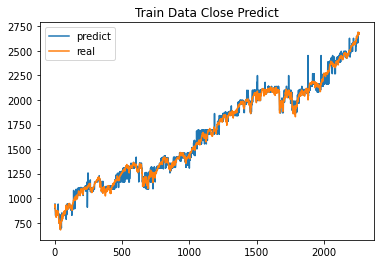

LR test predict accuracy: 0.450199203187251


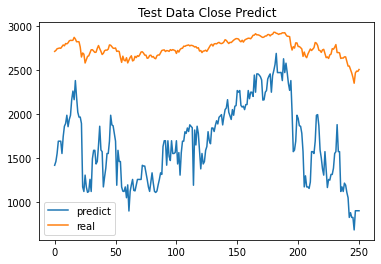

In [2]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def acc_compute(l1, l2):
    cnt = 0
    for i in range(1, len(l1)):
        if l1[i-1] < l1[i] and l2[i-1] < l2[i]:
            cnt+=1
        elif l1[i-1] > l1[i] and l2[i-1] > l2[i]:
            cnt+=1
        elif l1[i-1] == l1[i] and l2[i-1] == l2[i]:
            cnt+=1
    return cnt/len(l1)

model_LR = LogisticRegression(penalty='none', solver='lbfgs', max_iter=100)
model_LR.fit(train_x, train_y.astype('int'))
train_pred_y = model_LR.predict(train_x)
test_pred_y = model_LR.predict(test_x)

print("LR train predict accuracy: {}".format(acc_compute(train_y.tolist(), train_pred_y.tolist())))
plt.plot(range(len(train_pred_y)), train_pred_y, label='predict')
plt.plot(range(len(train_y)), train_y, label='real')
plt.legend(loc='best')
plt.title('Train Data Close Predict')
plt.show()

print("LR test predict accuracy: {}".format(acc_compute(test_y.tolist(), test_pred_y.tolist())))
plt.plot(range(len(test_pred_y)), test_pred_y, label='predict')
plt.plot(range(len(test_y)), test_y, label='real')
plt.legend(loc='best')
plt.title('Test Data Close Predict')
plt.show()

RNN LSTM train predict accuracy: 0.4968666069829902
RNN LSTM test predict accuracy: 0.5119047619047619


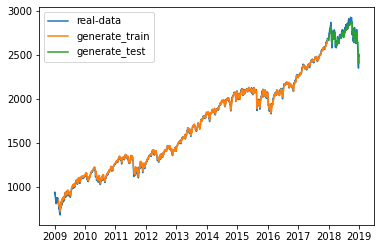

In [3]:
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

def generate_df_affect_by_n_days(series, n, index=False):
    if len(series) <= n:
        raise Exception("The Length of series is %d, while affect by (n=%d)." % (len(series), n))
    df = pd.DataFrame()
    for i in range(n):
        df['c%d' % i] = series.tolist()[i:-(n - i)]
    df['y'] = series.tolist()[n:]
    if index:
        df.index = series.index[n:]
    return df


def readData(column='Close Price', n=30, all_too=True, index=False):
    df_li = []
    df_li.append(pd.read_csv("./data/price_train.csv", index_col=0))
    df_test = pd.read_csv("./data/price_test.csv", index_col=0)
    df_li.append(df_test)
    df = pd.concat(df_li, axis=0, ignore_index=False)
    df.index = list(map(lambda x: datetime.datetime.strptime(x, "%d-%b-%Y"), df.index))
    df_column = df[column].copy()
    train_end = -len(df_test)
    df_column_train, df_column_test = df_column[:train_end], df_column[train_end - n:]
    df_generate_from_df_column_train = generate_df_affect_by_n_days(df_column_train, n, index=index)
    if all_too:
        return df_generate_from_df_column_train, df_column, df.index.tolist(), train_end
    return df_generate_from_df_column_train

class RNN(nn.Module):
    def __init__(self, input_size):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=64,
            num_layers=1,
            batch_first=True
        )
        self.out = nn.Sequential(
            nn.Linear(64, 1)
        )

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)  # None 表示 hidden state 會用全0的 state
        out = self.out(r_out)
        return out


class TrainSet(Dataset):
    def __init__(self, data):
        self.data, self.label = data[:, :-1].float(), data[:, -1].float()

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)


n = 30
LR = 0.0001 # 0.0001
EPOCH = 300 # 100
# train_end = -500

df, df_all, df_index, train_end = readData('Close Price', n=n)

df_all = np.array(df_all.tolist())
plt.plot(df_index, df_all, label='real-data')

df_numpy = np.array(df)

df_numpy_mean = np.mean(df_numpy)
df_numpy_std = np.std(df_numpy)

df_numpy = (df_numpy - df_numpy_mean) / df_numpy_std
df_tensor = torch.Tensor(df_numpy)

trainset = TrainSet(df_tensor)
trainloader = DataLoader(trainset, batch_size=10, shuffle=True)

rnn = RNN(n)
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)  # optimize all cnn parameters
loss_func = nn.MSELoss()

for step in range(EPOCH):
    for tx, ty in trainloader:
        output = rnn(torch.unsqueeze(tx, dim=0))
        loss = loss_func(torch.squeeze(output), ty)
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # back propagation, compute gradients
        optimizer.step()
    # print(step, loss)
    if step % 10:
        torch.save(rnn, 'rnn.pkl')
torch.save(rnn, 'rnn.pkl')
generate_data_train = []
generate_data_test = []

test_index = len(df_all) + train_end

df_all_normal = (df_all - df_numpy_mean) / df_numpy_std
df_all_normal_tensor = torch.Tensor(df_all_normal)
for i in range(n, len(df_all)):
    x = df_all_normal_tensor[i - n:i]
    x = torch.unsqueeze(torch.unsqueeze(x, dim=0), dim=0)
    y = rnn(x)
    if i < test_index:
        generate_data_train.append(torch.squeeze(y).detach().numpy() * df_numpy_std + df_numpy_mean)
    else:
        generate_data_test.append(torch.squeeze(y).detach().numpy() * df_numpy_std + df_numpy_mean)
plt.plot(df_index[n:train_end], generate_data_train, label='generate_train')
plt.plot(df_index[train_end:], generate_data_test, label='generate_test')

df_real_train = df_all[n:train_end]
df_real_test = df_all[train_end:]
print("RNN LSTM train predict accuracy: {}".format(acc_compute(df_real_train, generate_data_train)))
print("RNN LSTM test predict accuracy: {}".format(acc_compute(df_real_test, generate_data_test)))


plt.legend(loc='best')
plt.show()

# for date in df_index:
#     print(date)


RF train predict accuracy: 0.9522757401679187


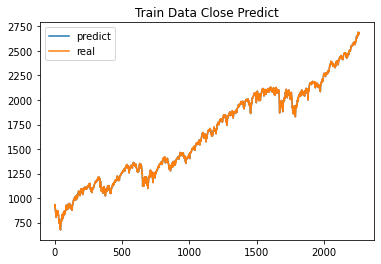

RF test predict accuracy: 0.44621513944223107


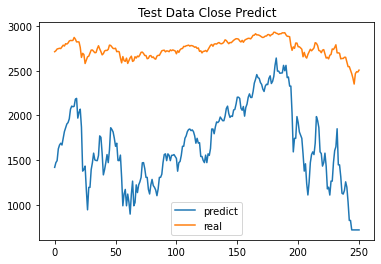

In [4]:
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier(n_estimators=100, random_state=10)
model_RF.fit(train_x, train_y.astype('int'))
train_pred_y = model_RF.predict(train_x)
test_pred_y = model_RF.predict(test_x)

print("RF train predict accuracy: {}".format(acc_compute(train_y.tolist(), train_pred_y.tolist())))
plt.plot(range(len(train_pred_y)), train_pred_y, label='predict')
plt.plot(range(len(train_y)), train_y, label='real')
plt.legend(loc='best')
plt.title('Train Data Close Predict')
plt.show()

print("RF test predict accuracy: {}".format(acc_compute(test_y.tolist(), test_pred_y.tolist())))
plt.plot(range(len(test_pred_y)), test_pred_y, label='predict')
plt.plot(range(len(test_y)), test_y, label='real')
plt.legend(loc='best')
plt.title('Test Data Close Predict')
plt.show()